Gene type bars plotted


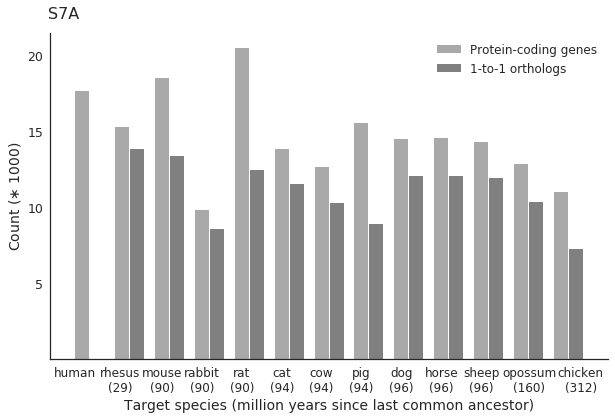

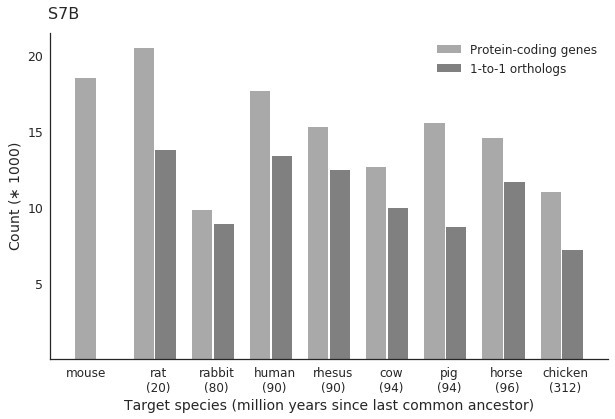

In [1]:
%matplotlib inline

import os as os
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import pandas as pd
import numpy as np
import numpy.random as rng
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

# What is this?
# bar charts of number of genes and
# number of 1:1 orthologs

date = '20180616'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
project_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm')
roi_folder = os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf')
ortholog_folder = os.path.join(fhgfs_base, 'refdata/orthologs/hdf')

ortholog_file = os.path.join(ortholog_folder, 'odb9_gene-orthologs.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_gene_bars = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
diss_folder = '/home/pebert/work/code/mpggit/dissertation/Figures'
save_figures = True
save_diss = False


def exec_gene_bars(out_folder):
    cache_file = os.path.join(cache_dir, '{}_plot_gene_ortho_bars.pck'.format(date))
        
    if os.path.isfile(cache_file):
        gene_bars = cache_data(cache_file, None)
    else:
        gene_bars = collect_gene_types()
        gene_bars = cache_data(cache_file, gene_bars)
    
    species, lca = read_references(species_file, lca_times_file)
    
    for k, v in species.items():
        org = v['kegg_org_code']
        gene_bars[(k, 'total')] = gene_bars[(org, 'total')]
    
    for ref, fk, subfolder in zip(['human', 'mouse'], ['S7A', 'S7B'], ['supp', 'supp']):
        
        if ref == 'human':
            trg_species = set(list(species.keys())) - set(['frog', 'lizard'])
        else:
            trg_species = set(list(species.keys())) - set(['frog', 'lizard', 'opossum', 'sheep', 'dog', 'cat'])
        lca = dict([(k, v) for k, v in lca.items() if k[0] in trg_species and k[1] in trg_species])
    
        fig, exart = plot_gene_bars(gene_bars, ref, lca, fk, save_diss)
        if save_figures:
            outname = 'fig_{}_gene-ortho'.format(fk)
            if save_diss:
                out_folder = diss_folder
                subfolder = 'crossspecies'
            else:
                subfolder = 'supp'
            
            if not save_diss:
                outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')

                outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)

            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    
    return True


def cache_data(cache_file, genebars):
    
    if os.path.isfile(cache_file):
        with open(cache_file, 'rb') as cache:
            genebars = pck.load(cache)
    else:
        with open(cache_file, 'wb') as cache:
            _ = pck.dump(genebars, cache)
    return genebars
  
    
def plot_gene_bars(gene_counts, ref_spec, lca_dist, fkey, diss_version):
    """
    """   
    fig, ax = plt.subplots(figsize=(10, 6))
    extra_artists = []
    
    species_sorting = sorted([(d, q) for (t, q), d in lca_dist.items() if t == ref_spec])
        
    x_totals = np.arange(1, 2 * len(species_sorting), 2, dtype=np.float16)
    x_orthos = np.arange(3.75, x_totals.max() + 1, 2)
        
    y_totals = [gene_counts[(s, 'total')] for d, s in species_sorting]
    y_orthos = [gene_counts[(ref_spec, s, 'ortho')] for d, s in species_sorting if s != ref_spec]
    
    barwidth = 0.7
    
    ax.bar(x_totals, y_totals, label='Protein-coding genes',
           color='darkgrey', width=barwidth)
    ax.bar(x_orthos, y_orthos, label='1-to-1 orthologs',
           color='grey', width=barwidth)
    
    ax.set_yticks([5000, 10000, 15000, 20000])
    ax.set_yticklabels(['5', '10', '15', '20'])
    ax.set_ylabel(r'Count ($\ast$ 1000)', fontsize=14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not diss_version:
        tt = ax.set_title(fkey, fontsize=16)
        tt.set_position([0.025, 1.025])
    
    ax.legend(loc='upper right', fontsize=12)

    x_labels = [ref_spec] + ['{}\n({})'.format(s, d) for d, s in species_sorting[1:]]
    
    x_ticks = x_totals
    if ref_spec == 'human':
        x_ticks[-1] += 1
        x_ticks[-2] += 0.4
        x_ticks[0] -= 0.4
        x_ticks[1] -= 0.1
    else:
        x_ticks[1:] += 0.5
        
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=12)
    
    ax.set_xlabel('Target species (million years since last common ancestor)', fontsize=14)

    return fig, extra_artists


def read_references(species, lca):
    """
    """
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist
  

def collect_gene_types():
    print('collecting')
    gene_collector = col.Counter()
    gene_columns = ['chrom', 'name', 'symbol']
    
    ortho_genes = dict()
    with pd.HDFStore(ortholog_file, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/auto/pairs')]
        for k in load_keys:
            _, _, _, s1, s2 = k.split('/')
            if s1 == 'human' or s1 == 'mouse':
                trg = s1
                qry = s2
            elif s2 == 'human' or s2 == 'mouse':
                trg = s2
                qry = s1
            else:
                continue
            data = hdf[k]
            gene_collector[(trg, qry, 'ortho')] = data.shape[0]
    
    for roi_file in os.listdir(roi_folder):
        if '.body.' in roi_file and roi_file.endswith('.h5'):
            org = roi_file.split('_')[0]
            roi_path = os.path.join(roi_folder, roi_file)
            with pd.HDFStore(roi_path, 'r') as hdf:
                md = hdf['metadata']
                gene_collector[(org, 'total')] = int(md['numreg'].sum())
    
    return gene_collector
                

if run_exec_gene_bars:
    execd = exec_gene_bars(out_folder)
    print('Gene type bars plotted')
